In [1]:
%matplotlib inline

import os
import sys

import numpy as np
import torch
import torch.nn as nn
import gpytorch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import copy
from torch.utils.data import Dataset, DataLoader,random_split, Subset
from tqdm import tqdm

sys.path.append(os.path.abspath('..'))
from GP import *
from Models.GPVAE_pendulum import GPVAE
# from Models.GPVAE import GPVAE

import warnings
# Suppress only the specific GPInputWarning coming from the exact_gp.py file
warnings.filterwarnings(
    "ignore", 
    message="The input matches the stored training data. Did you forget to call model.train()?", 
    module=".*exact_gp"
)

In [2]:
class PendulumDataset(Dataset):
    def __init__(self, df):
        self.df = df
        self.unique_intervals = df['interval'].unique()

    def __len__(self):
        return len(self.unique_intervals)

    def __getitem__(self, idx):
        batch = self.unique_intervals[idx]
        id = self.df['interval'] == batch
        theta = torch.tensor(self.df[id]['theta'].to_numpy(), dtype=torch.float32)
        t = torch.tensor(self.df[id]['t'].to_numpy() / 10, dtype=torch.float32)  # Normalize time

        # Concatenate theta and t as input batch
        x_batch = torch.cat((theta.unsqueeze(1), t.unsqueeze(1)), axis=1)
        return x_batch # Also return omega for plotting

# Load the dataset
df_damped = pd.read_csv("../Data/damped_pendulum_data.csv")
df_damped['interval'] = df_damped['omega'].astype('category').cat.codes
df_damped['theta'] = df_damped['theta']
# df_damped = df_damped[df_damped['t'] <= 10]

dataset = PendulumDataset(df_damped)

train_ratio = 0.7
test_ratio = 1-train_ratio

# Calculate split sizes
total_size = len(dataset)
train_size = int(train_ratio * total_size)
test_size = total_size - train_size

seed = 42
generator = torch.Generator().manual_seed(seed)

# Split the dataset
train_subset, test_subset = random_split(
    dataset,
    [train_size, test_size],
    generator=generator
)
train_loader = DataLoader(train_subset, batch_size=1, shuffle=False)
val_loader = DataLoader(test_subset, batch_size=1, shuffle=False)


In [3]:
df_damped.head()

theta        t  omega  interval
0 -0.154574  0.00000    1.5         0
1 -0.172141  0.10101    1.5         0
2 -0.188483  0.20202    1.5         0
3 -0.317860  0.30303    1.5         0
4 -0.150701  0.40404    1.5         0

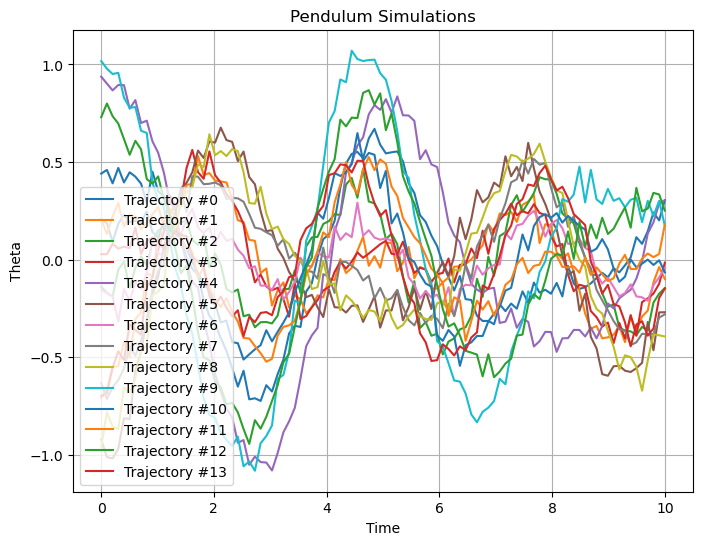

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

for i, x_batch in enumerate(train_loader):
    # x_batch has shape (1, N, 2) if batch_size=1
    x_batch = x_batch.squeeze(0)  # Now shape is (N, 2)

    # Extract theta and time
    theta_values = x_batch[:, 0].numpy()
    time_values = x_batch[:, 1].numpy() * 10  # Reverse normalization

    plt.plot(time_values, theta_values, label=f'Trajectory #{i}')

plt.xlabel("Time")
plt.ylabel("Theta")
plt.title("Pendulum Simulations")
plt.legend()
plt.grid()
plt.show()


In [5]:
kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=1.5))
# kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RQKernel())
# Initialize the VAE
torch.manual_seed(42)
model = GPVAE(GP_inf = GP_inference(kernel),# GP_inference(kernel,mean_GP), 
              activation_decoder=nn.ReLU(),
              # activation_decoder=nn.Tanh(),
              # activation_encoder=nn.ReLU(),
              hidden_layers_encoder=[10],
              # hidden_layers_decoder=[5,5]
              )

In [6]:
gp_params = []
base_params = []

for name, param in model.named_parameters():
    if 'GP' in name:
        gp_params.append(param)  # Gaussian Process parameters
    else:
        base_params.append(param)  # Other parameters

base_lr = 0.001  # Learning rate for base parameters
gp_lr = 0.0001  # Learning rate for GP parameters
# Create separate parameter groups in the optimizer
opt = torch.optim.Adam([
    {'params': base_params, 'lr': base_lr},
    {'params': gp_params, 'lr': gp_lr}
])
opt.zero_grad()


In [7]:
for i, x_batch in enumerate(train_loader):  # No need to unpack (omega is not returned)
    x_batch = x_batch.squeeze(0)  # Remove batch dimension, now shape is (N, 2)

    t_i = x_batch[:, 1].numpy() * 10  # Reverse normalization
    t_uni = torch.tensor(t_i)  # Convert to torch tensor

    print(f"Iteration {i}: t_uni shape = {t_uni.shape}")  # Debug print

    if i == 0:
        break  # Stop after the first two iterations


Iteration 0: t_uni shape = torch.Size([100])


In [8]:
t_uni

tensor([ 0.0000,  0.1010,  0.2020,  0.3030,  0.4040,  0.5051,  0.6061,  0.7071,
         0.8081,  0.9091,  1.0101,  1.1111,  1.2121,  1.3131,  1.4141,  1.5152,
         1.6162,  1.7172,  1.8182,  1.9192,  2.0202,  2.1212,  2.2222,  2.3232,
         2.4242,  2.5253,  2.6263,  2.7273,  2.8283,  2.9293,  3.0303,  3.1313,
         3.2323,  3.3333,  3.4343,  3.5354,  3.6364,  3.7374,  3.8384,  3.9394,
         4.0404,  4.1414,  4.2424,  4.3434,  4.4444,  4.5455,  4.6465,  4.7475,
         4.8485,  4.9495,  5.0505,  5.1515,  5.2525,  5.3535,  5.4545,  5.5556,
         5.6566,  5.7576,  5.8586,  5.9596,  6.0606,  6.1616,  6.2626,  6.3636,
         6.4646,  6.5657,  6.6667,  6.7677,  6.8687,  6.9697,  7.0707,  7.1717,
         7.2727,  7.3737,  7.4747,  7.5758,  7.6768,  7.7778,  7.8788,  7.9798,
         8.0808,  8.1818,  8.2828,  8.3838,  8.4848,  8.5859,  8.6869,  8.7879,
         8.8889,  8.9899,  9.0909,  9.1919,  9.2929,  9.3939,  9.4949,  9.5960,
         9.6970,  9.7980,  9.8990, 10.00

Training Progress:   5%|▍         | 49/1000 [00:03<01:16, 12.42it/s]

Epoch 50:
  Training - Loss = 0.0712, KL = 0.1596, MSE = 0.0871, CE = 0.8568
  Validation - Loss = 0.0569, KL = 0.2190, MSE = 0.0788, CE = 0.8701
  Mean q_mu = -0.0914, Mean q_var = 0.1353


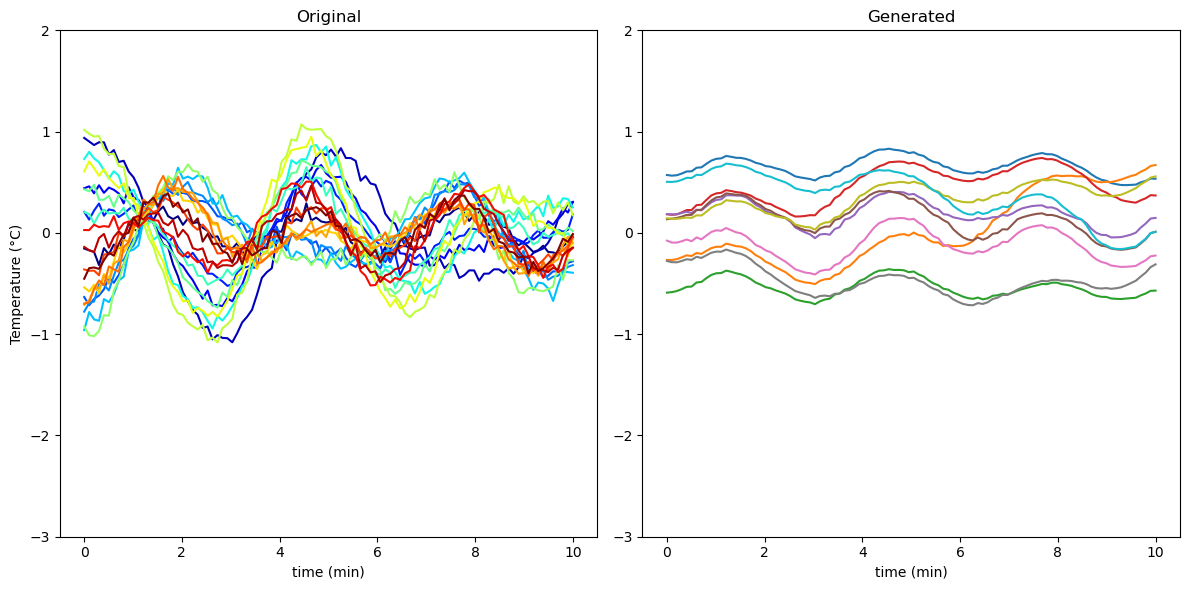

Training Progress:  10%|▉         | 99/1000 [00:08<01:10, 12.69it/s]

Epoch 100:
  Training - Loss = 0.0652, KL = 0.1370, MSE = 0.0789, CE = 0.8334
  Validation - Loss = 0.0583, KL = 0.1977, MSE = 0.0781, CE = 0.8473
  Mean q_mu = -0.0940, Mean q_var = 0.1353


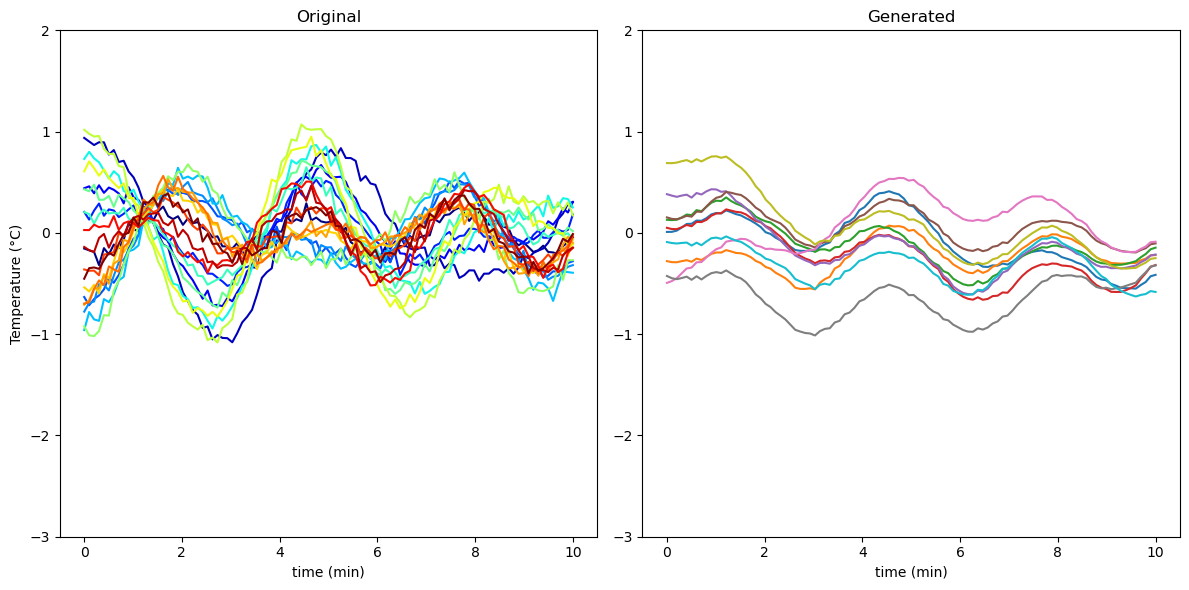

Training Progress:  15%|█▍        | 149/1000 [00:12<01:09, 12.20it/s]

Epoch 150:
  Training - Loss = 0.0608, KL = 0.1330, MSE = 0.0741, CE = 0.7991
  Validation - Loss = 0.0542, KL = 0.1892, MSE = 0.0731, CE = 0.8162
  Mean q_mu = -0.0548, Mean q_var = 0.1353


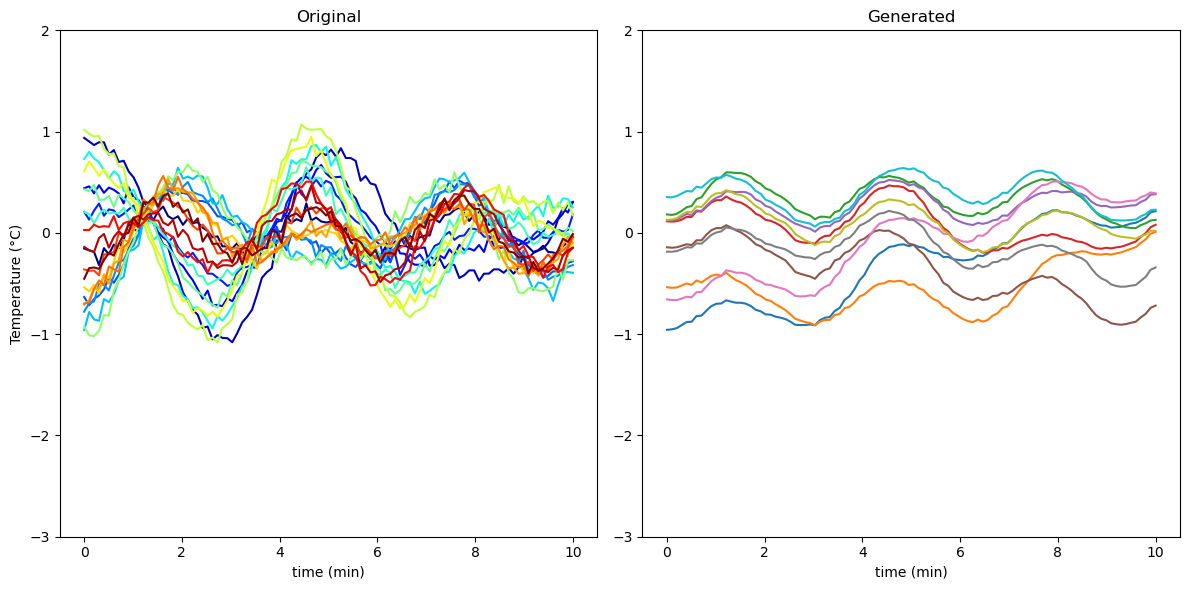

Training Progress:  20%|█▉        | 199/1000 [00:16<01:05, 12.22it/s]

Epoch 200:
  Training - Loss = 0.0570, KL = 0.1230, MSE = 0.0693, CE = 0.7776
  Validation - Loss = 0.0490, KL = 0.1791, MSE = 0.0669, CE = 0.7926
  Mean q_mu = -0.0498, Mean q_var = 0.1353


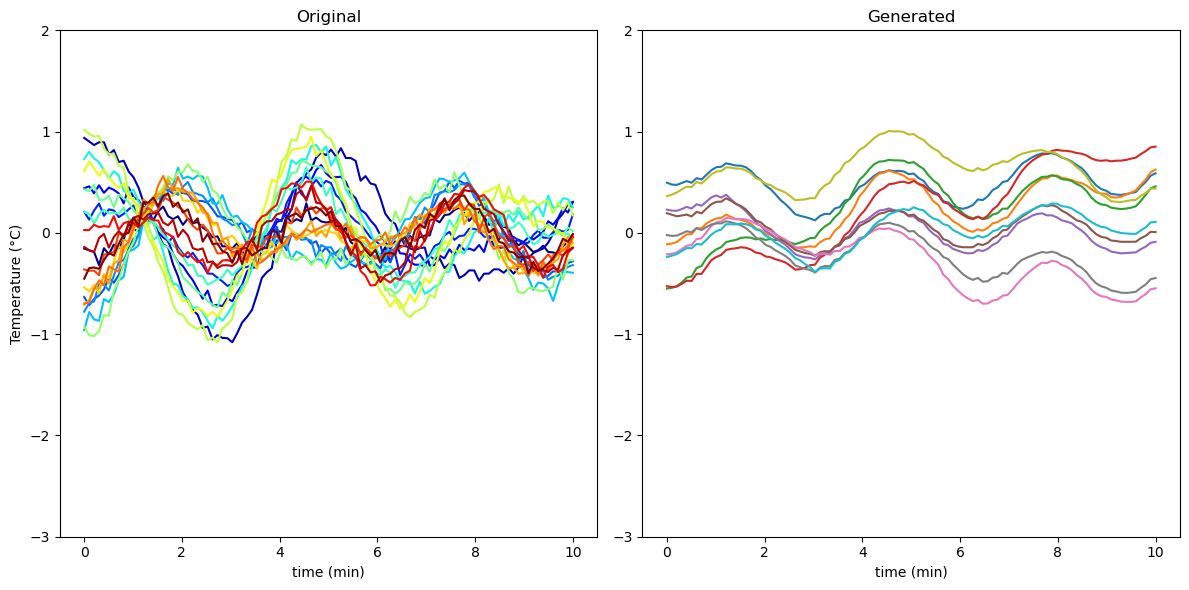

Training Progress:  25%|██▍       | 249/1000 [00:20<01:01, 12.15it/s]

Epoch 250:
  Training - Loss = 0.0560, KL = 0.1234, MSE = 0.0683, CE = 0.7486
  Validation - Loss = 0.0442, KL = 0.1737, MSE = 0.0616, CE = 0.7656
  Mean q_mu = -0.0280, Mean q_var = 0.1353


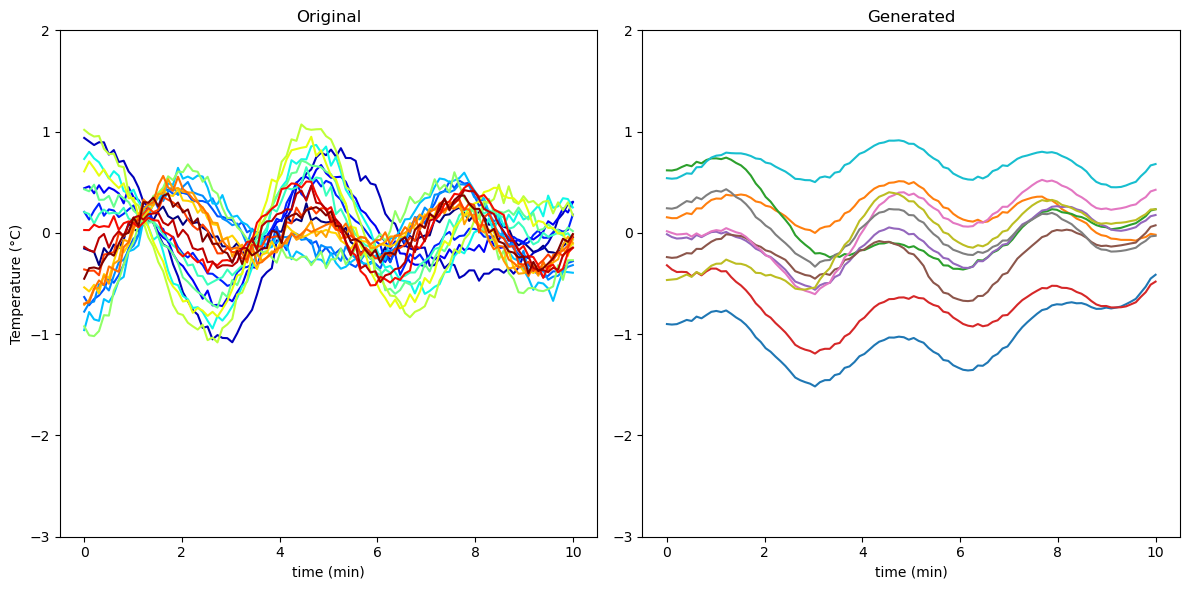

Training Progress:  30%|██▉       | 299/1000 [00:25<00:57, 12.14it/s]

Epoch 300:
  Training - Loss = 0.0541, KL = 0.1276, MSE = 0.0668, CE = 0.7200
  Validation - Loss = 0.0445, KL = 0.1732, MSE = 0.0618, CE = 0.7367
  Mean q_mu = -0.0441, Mean q_var = 0.1353


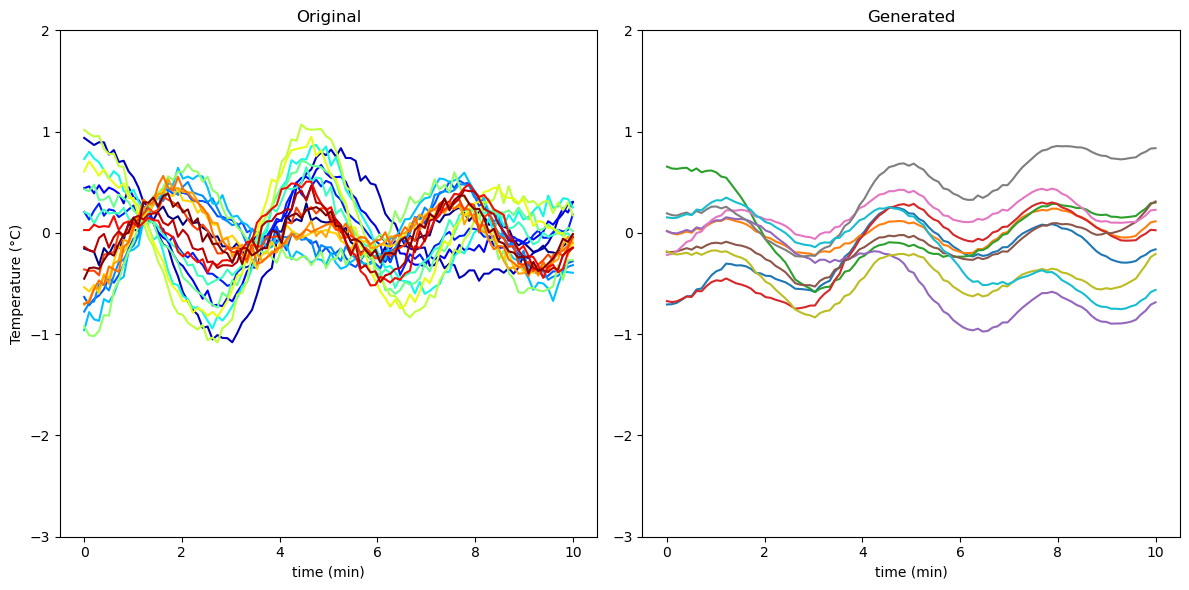

Training Progress:  35%|███▍      | 349/1000 [00:29<00:54, 11.95it/s]

Epoch 350:
  Training - Loss = 0.0442, KL = 0.1373, MSE = 0.0580, CE = 0.6901
  Validation - Loss = 0.0391, KL = 0.1760, MSE = 0.0567, CE = 0.7073
  Mean q_mu = -0.0454, Mean q_var = 0.1353


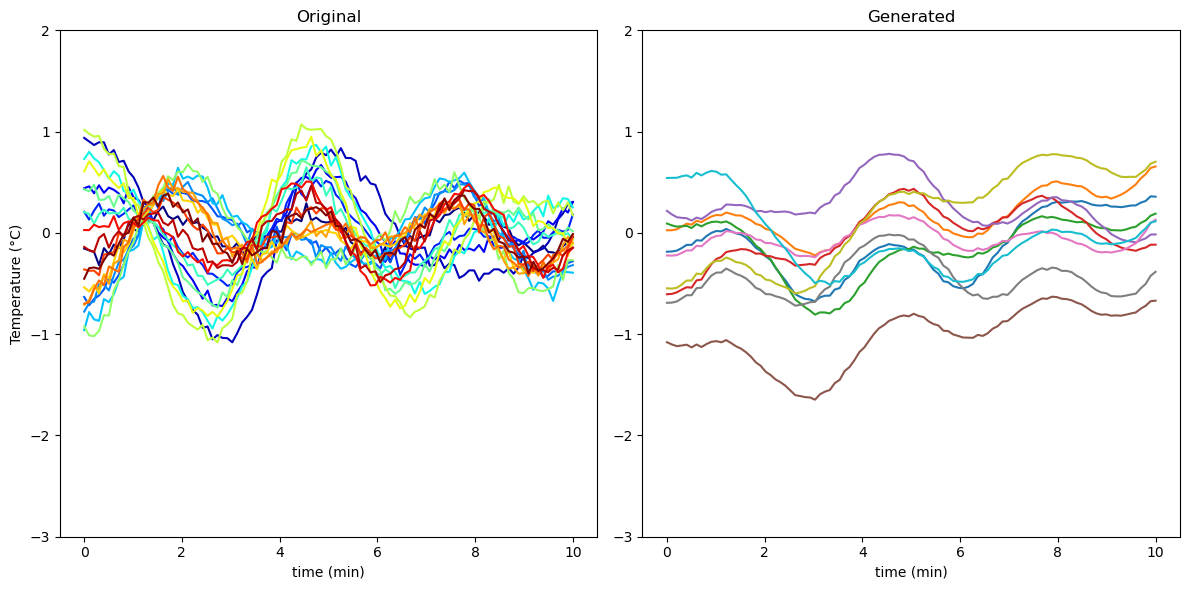

Training Progress:  40%|███▉      | 399/1000 [00:33<00:49, 12.08it/s]

Epoch 400:
  Training - Loss = 0.0468, KL = 0.1297, MSE = 0.0598, CE = 0.6768
  Validation - Loss = 0.0384, KL = 0.1650, MSE = 0.0549, CE = 0.6941
  Mean q_mu = -0.0377, Mean q_var = 0.1353


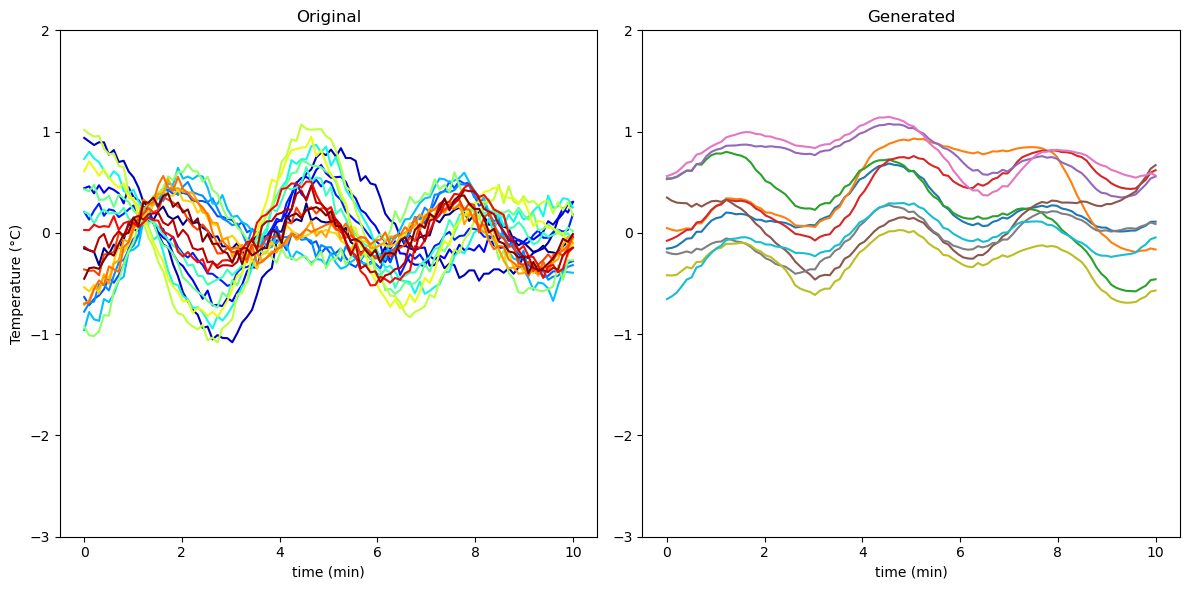

Training Progress:  45%|████▍     | 449/1000 [00:38<00:46, 11.95it/s]

Epoch 450:
  Training - Loss = 0.0402, KL = 0.1364, MSE = 0.0539, CE = 0.6548
  Validation - Loss = 0.0348, KL = 0.1678, MSE = 0.0516, CE = 0.6703
  Mean q_mu = -0.0449, Mean q_var = 0.1353


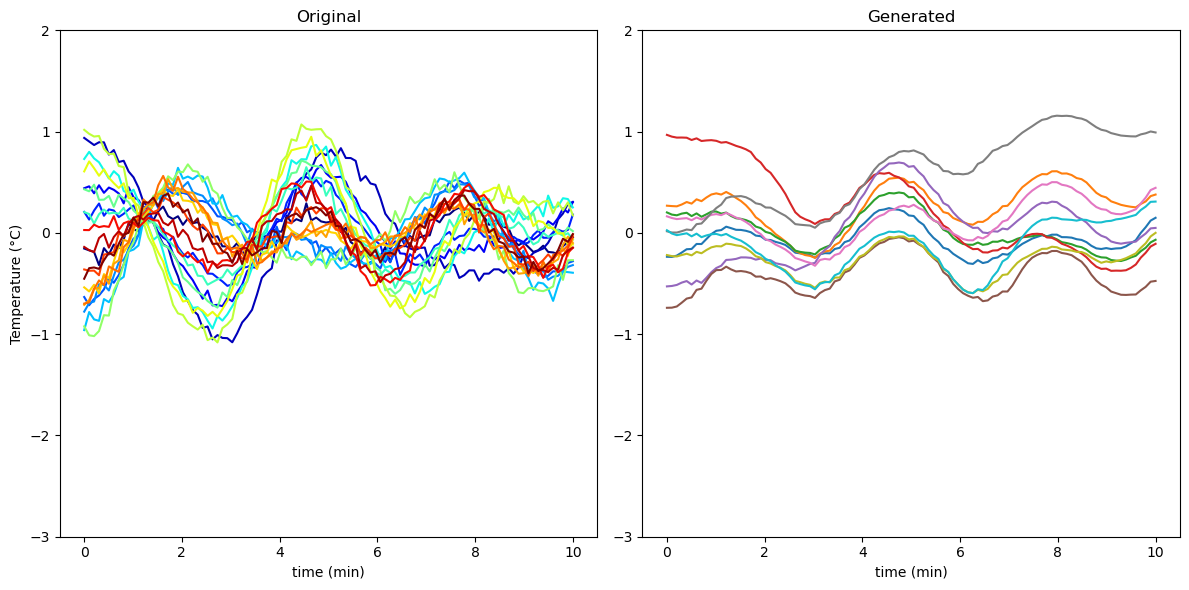

Training Progress:  50%|████▉     | 499/1000 [00:42<00:41, 12.01it/s]

Epoch 500:
  Training - Loss = 0.0347, KL = 0.1376, MSE = 0.0484, CE = 0.6390
  Validation - Loss = 0.0311, KL = 0.1645, MSE = 0.0476, CE = 0.6540
  Mean q_mu = -0.0512, Mean q_var = 0.1353


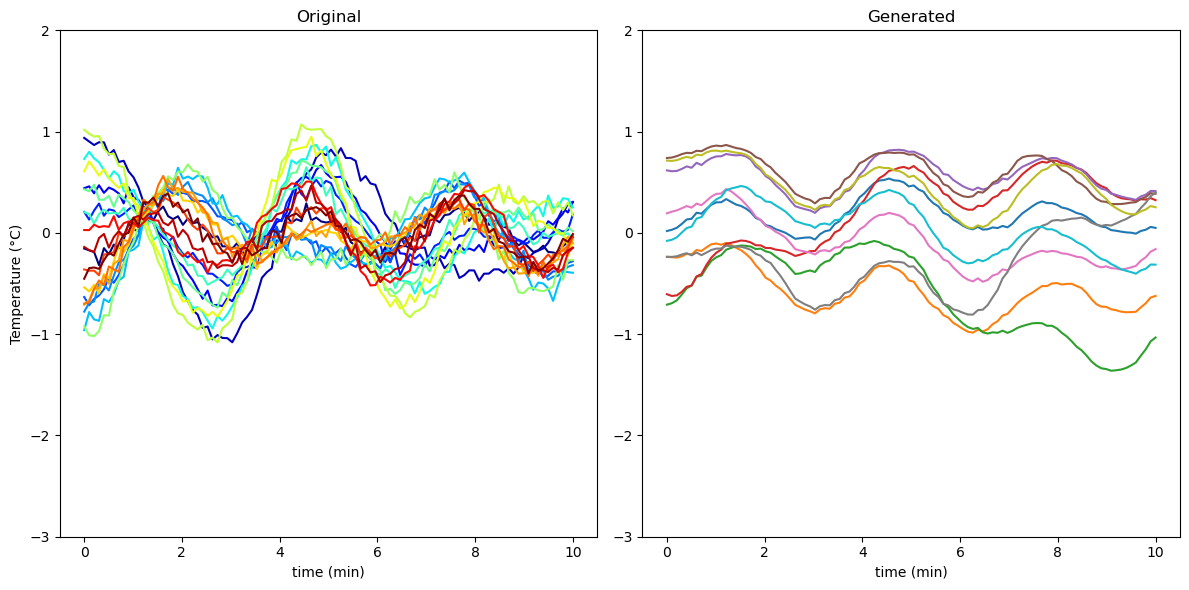

Training Progress:  55%|█████▍    | 549/1000 [00:47<00:39, 11.52it/s]

Epoch 550:
  Training - Loss = 0.0323, KL = 0.1437, MSE = 0.0467, CE = 0.6223
  Validation - Loss = 0.0316, KL = 0.1690, MSE = 0.0485, CE = 0.6340
  Mean q_mu = -0.0665, Mean q_var = 0.1353


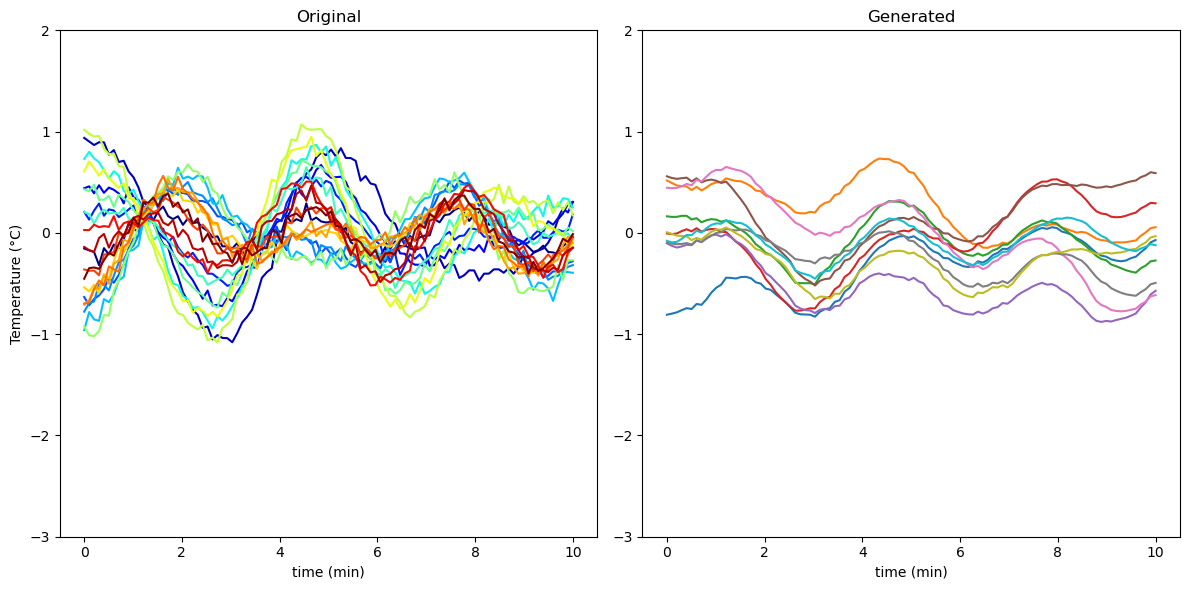

Training Progress:  60%|█████▉    | 599/1000 [00:51<00:33, 11.95it/s]

Epoch 600:
  Training - Loss = 0.0302, KL = 0.1491, MSE = 0.0451, CE = 0.6078
  Validation - Loss = 0.0225, KL = 0.1684, MSE = 0.0393, CE = 0.6201
  Mean q_mu = -0.0681, Mean q_var = 0.1353


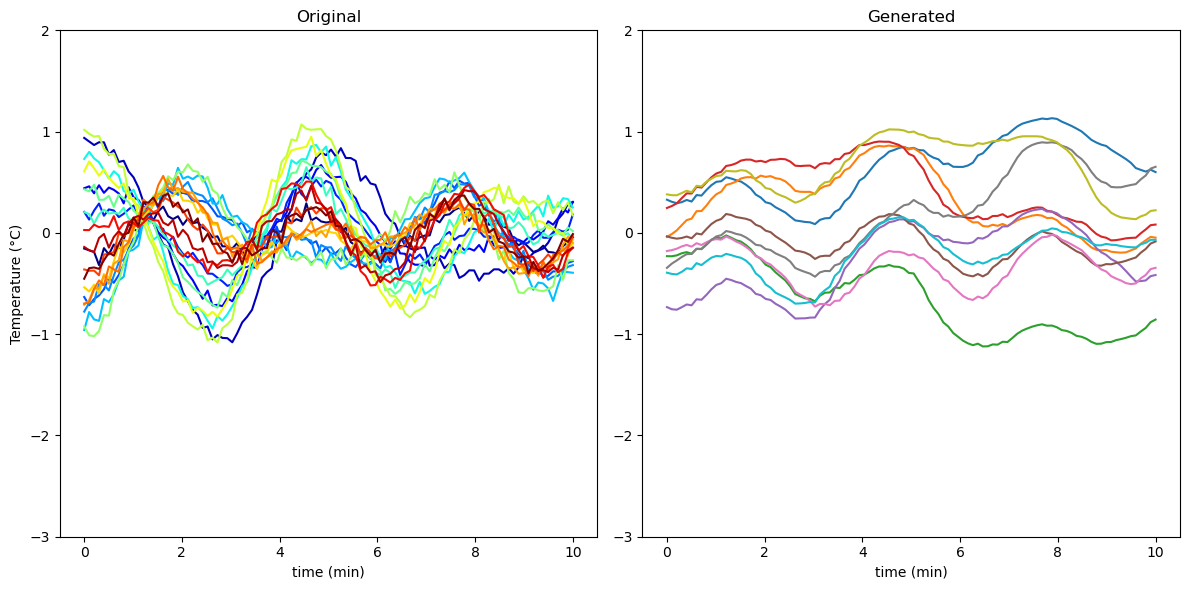

Training Progress:  65%|██████▍   | 649/1000 [00:55<00:29, 12.06it/s]

Epoch 650:
  Training - Loss = 0.0249, KL = 0.1431, MSE = 0.0392, CE = 0.6012
  Validation - Loss = 0.0280, KL = 0.1633, MSE = 0.0444, CE = 0.6105
  Mean q_mu = -0.0879, Mean q_var = 0.1353


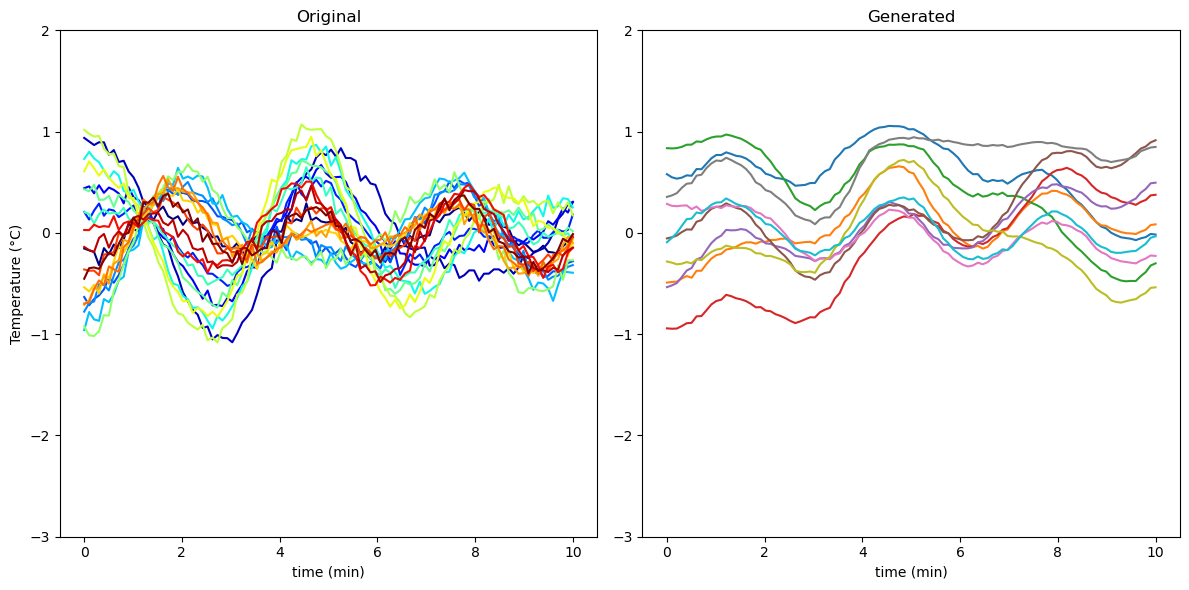

Training Progress:  70%|██████▉   | 699/1000 [01:00<00:25, 11.77it/s]

Epoch 700:
  Training - Loss = 0.0240, KL = 0.1502, MSE = 0.0390, CE = 0.5893
  Validation - Loss = 0.0250, KL = 0.1660, MSE = 0.0416, CE = 0.5980
  Mean q_mu = -0.0825, Mean q_var = 0.1353


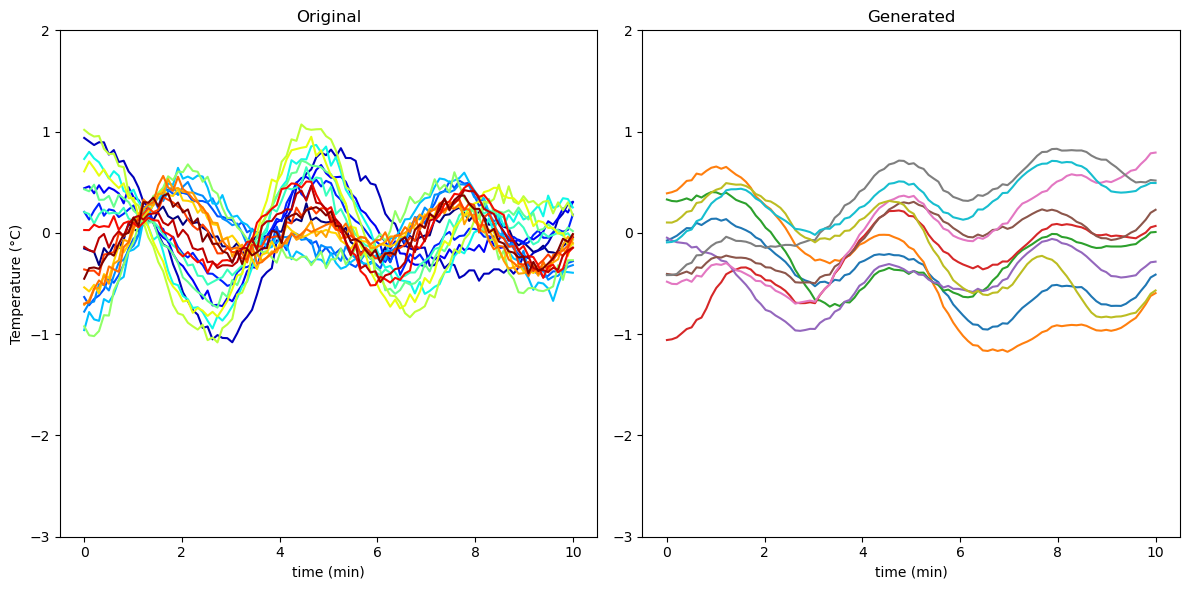

Training Progress:  75%|███████▍  | 749/1000 [01:04<00:20, 12.29it/s]

Epoch 750:
  Training - Loss = 0.0231, KL = 0.1576, MSE = 0.0389, CE = 0.5789
  Validation - Loss = 0.0184, KL = 0.1705, MSE = 0.0354, CE = 0.5864
  Mean q_mu = -0.0592, Mean q_var = 0.1353


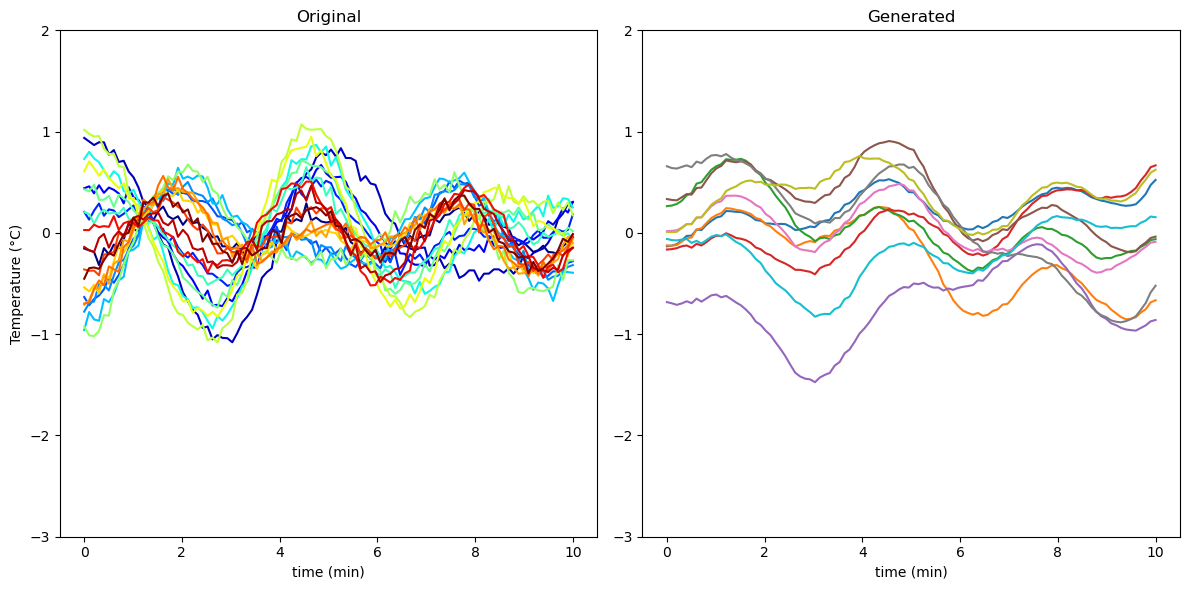

Training Progress:  80%|███████▉  | 799/1000 [01:08<00:17, 11.76it/s]

Epoch 800:
  Training - Loss = 0.0187, KL = 0.1650, MSE = 0.0352, CE = 0.5703
  Validation - Loss = 0.0161, KL = 0.1753, MSE = 0.0337, CE = 0.5767
  Mean q_mu = -0.0682, Mean q_var = 0.1353


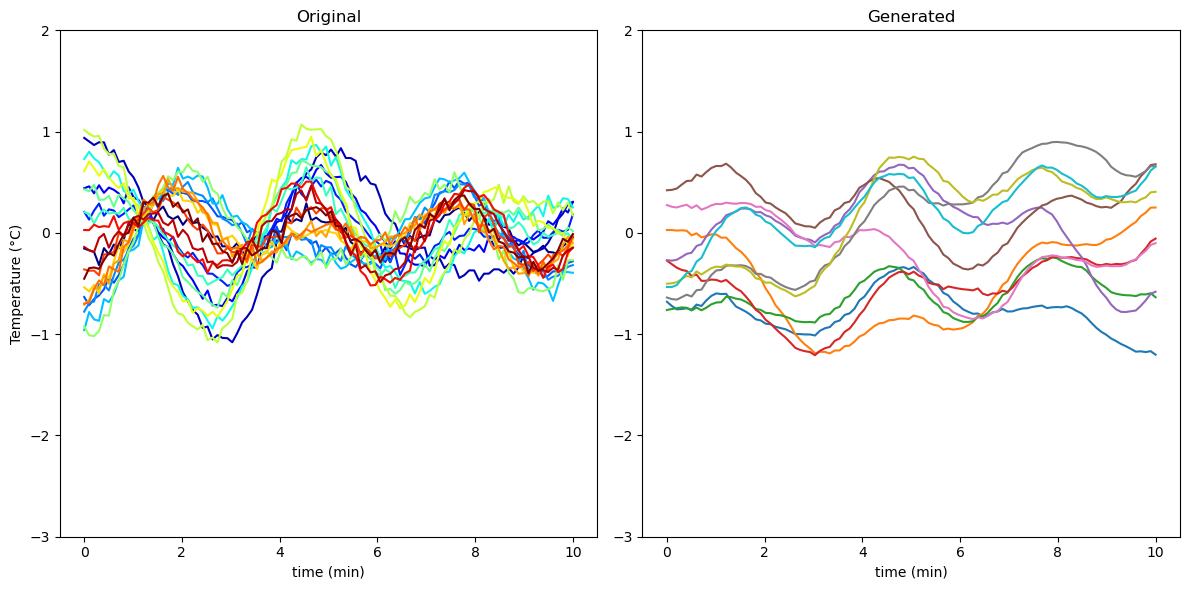

Training Progress:  85%|████████▍ | 849/1000 [01:13<00:13, 11.58it/s]

Epoch 850:
  Training - Loss = 0.0153, KL = 0.1709, MSE = 0.0324, CE = 0.5638
  Validation - Loss = 0.0157, KL = 0.1806, MSE = 0.0338, CE = 0.5686
  Mean q_mu = -0.0792, Mean q_var = 0.1353


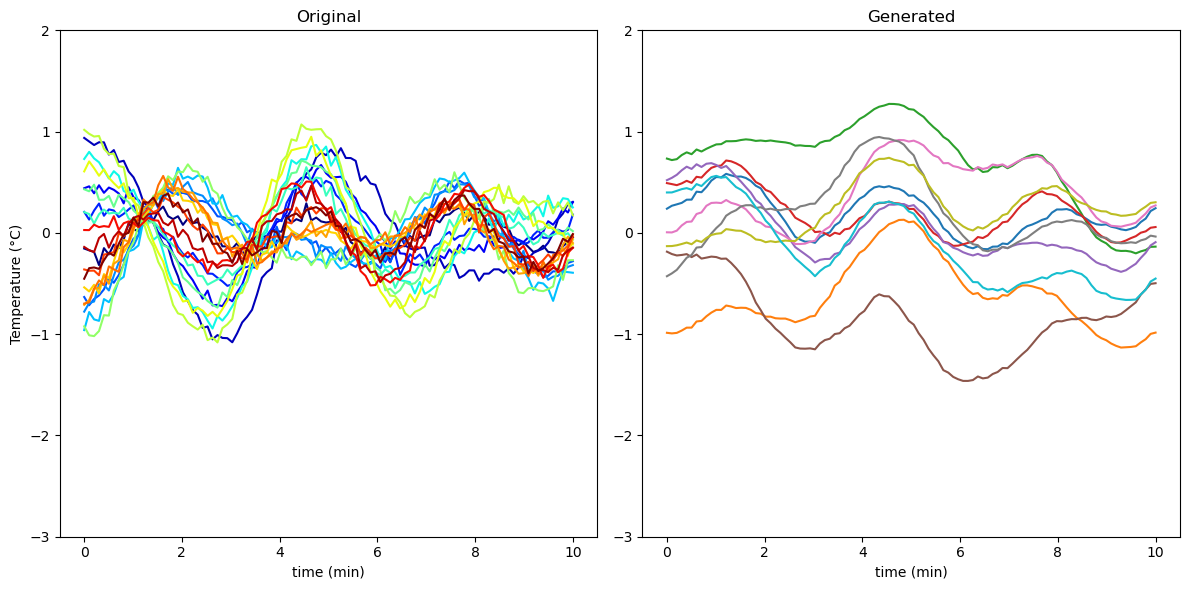

Training Progress:  90%|████████▉ | 899/1000 [01:17<00:08, 11.78it/s]

Epoch 900:
  Training - Loss = 0.0148, KL = 0.1752, MSE = 0.0323, CE = 0.5594
  Validation - Loss = 0.0104, KL = 0.1841, MSE = 0.0289, CE = 0.5629
  Mean q_mu = -0.0838, Mean q_var = 0.1353


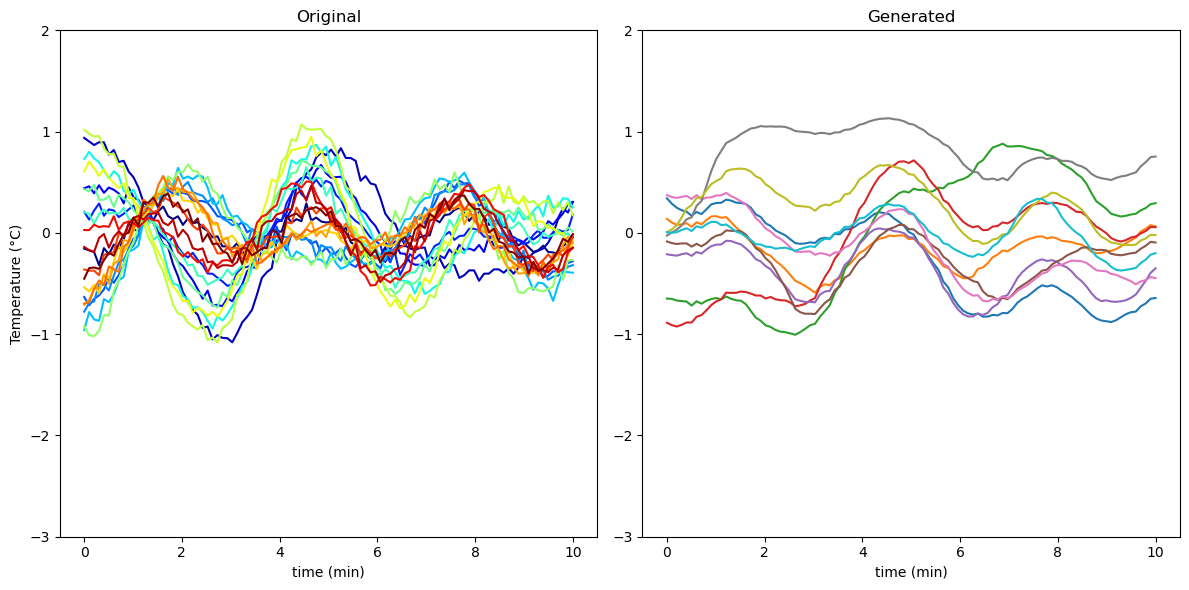

Training Progress:  95%|█████████▍| 949/1000 [01:21<00:04, 11.67it/s]

Epoch 950:
  Training - Loss = 0.0125, KL = 0.1813, MSE = 0.0306, CE = 0.5554
  Validation - Loss = 0.0115, KL = 0.1901, MSE = 0.0305, CE = 0.5576
  Mean q_mu = -0.0823, Mean q_var = 0.1353


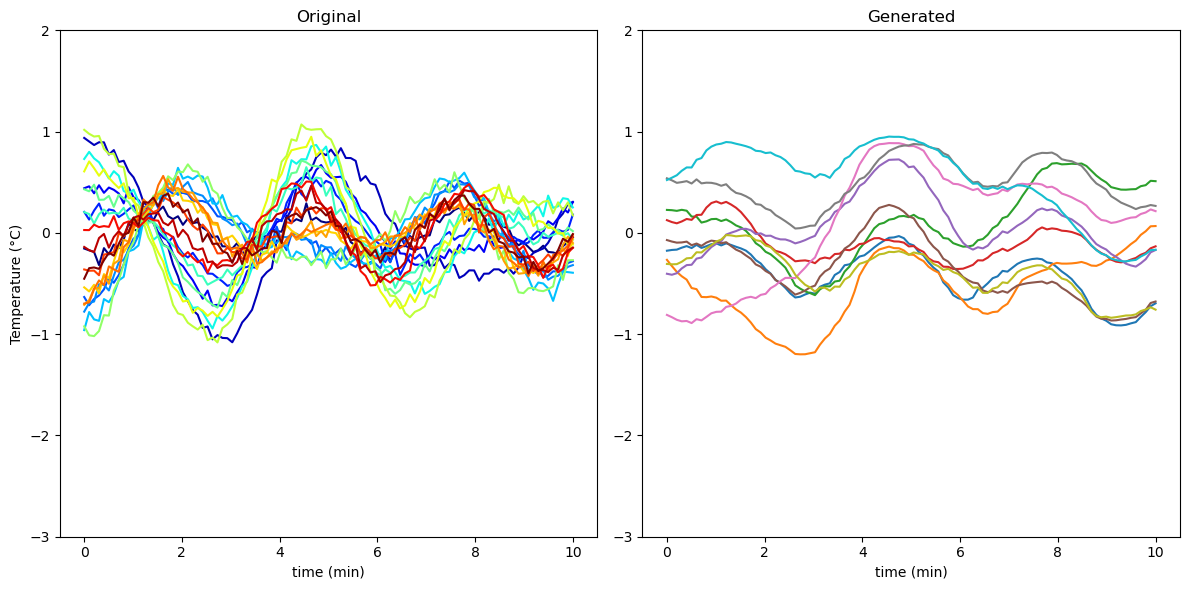

Training Progress: 100%|█████████▉| 999/1000 [01:26<00:00, 12.95it/s]

Epoch 1000:
  Training - Loss = 0.0099, KL = 0.1878, MSE = 0.0287, CE = 0.5524
  Validation - Loss = 0.0080, KL = 0.1931, MSE = 0.0273, CE = 0.5549
  Mean q_mu = -0.0942, Mean q_var = 0.1353


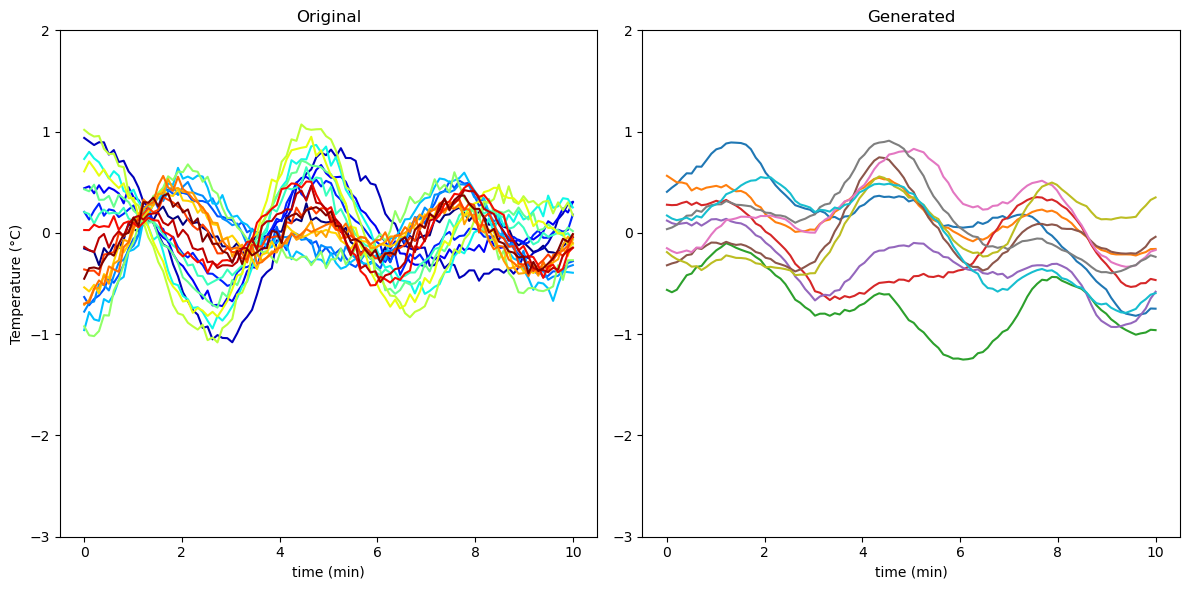

Training Progress: 100%|██████████| 1000/1000 [01:26<00:00, 11.60it/s]


In [9]:
beta = 0.1
# beta = 10
num_epochs = 1000
torch.manual_seed(123)
metrics = model.fit(train_loader, val_loader, 
                    opt, beta, num_epochs, 
                    t_uni=t_uni/10, 
                    num_samples=10, 
                    ylim=(-3,2), 
                    df=df_damped, 
                    plot=True)# model.fit(train_loader, val_loader, opt, beta, num_epochs)

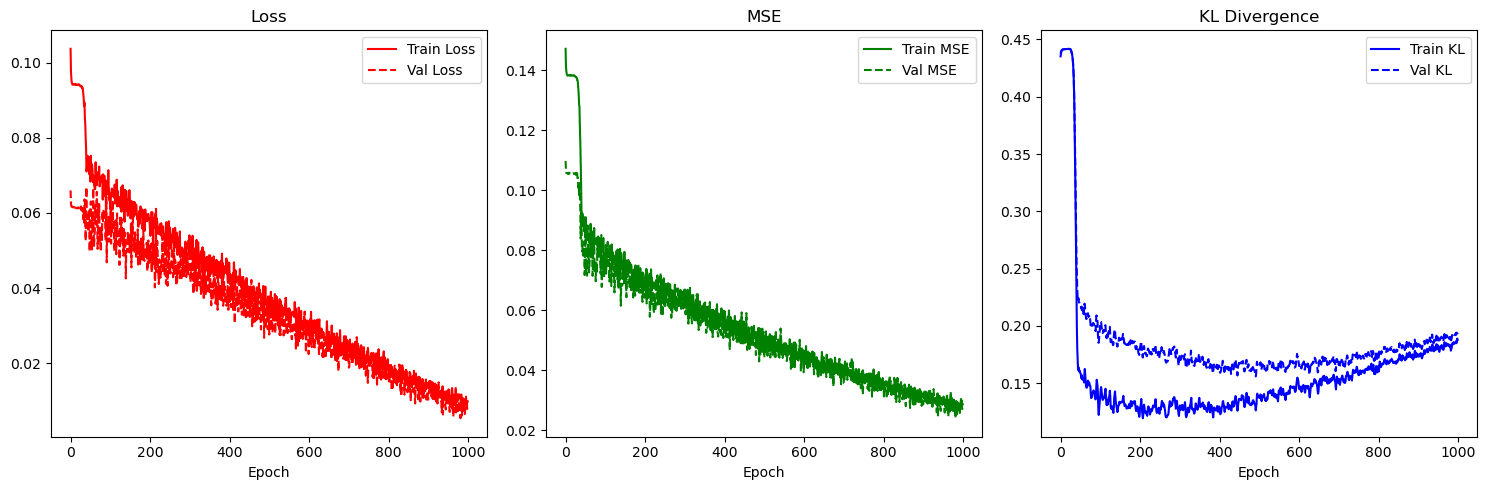

In [10]:
# Extracting training and validation metrics from the dictionary
epochs = range(num_epochs)
train_loss = metrics['train_loss']
val_loss = metrics['val_loss']
train_mse = metrics['train_mse']
val_mse = metrics['val_mse']
train_KL = metrics['train_KL']
val_KL = metrics['val_KL']

# Create subplots for Loss, MSE, and KL Divergence with both train and validation metrics
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Loss plot (train and validation)
axs[0].plot(epochs, train_loss, 'r-', label='Train Loss')
axs[0].plot(epochs, val_loss, 'r--', label='Val Loss')
axs[0].set_title('Loss')
axs[0].set_xlabel('Epoch')
axs[0].legend()

# MSE plot (train and validation)
axs[1].plot(epochs, train_mse, 'g-', label='Train MSE')
axs[1].plot(epochs, val_mse, 'g--', label='Val MSE')
axs[1].set_title('MSE')
axs[1].set_xlabel('Epoch')
axs[1].legend()

# KL Divergence plot (train and validation)
axs[2].plot(epochs, train_KL, 'b-', label='Train KL')
axs[2].plot(epochs, val_KL, 'b--', label='Val KL')
axs[2].set_title('KL Divergence')
axs[2].set_xlabel('Epoch')
axs[2].legend()

# Adjust layout
plt.tight_layout()
plt.show()

In [11]:
# Initialize lists to collect only the required results
x_hat_l, q_mu_l, q_var_l = [], [], []

for x_batch in dataset:
    with torch.no_grad():
        x_hat_i, _, _, _, q_mu_i, q_var_i = model(x_batch.squeeze())  # Only retrieve required outputs
        
        # Append results to respective lists
        x_hat_l.append(x_hat_i)
        q_mu_l.append(q_mu_i)
        q_var_l.append(q_var_i)
        
mean_q_mu = sum(q_mu_l) / len(q_mu_l)
mean_q_var = sum(q_var_l) / len(q_var_l)

In [12]:
t_uni

tensor([ 0.0000,  0.1010,  0.2020,  0.3030,  0.4040,  0.5051,  0.6061,  0.7071,
         0.8081,  0.9091,  1.0101,  1.1111,  1.2121,  1.3131,  1.4141,  1.5152,
         1.6162,  1.7172,  1.8182,  1.9192,  2.0202,  2.1212,  2.2222,  2.3232,
         2.4242,  2.5253,  2.6263,  2.7273,  2.8283,  2.9293,  3.0303,  3.1313,
         3.2323,  3.3333,  3.4343,  3.5354,  3.6364,  3.7374,  3.8384,  3.9394,
         4.0404,  4.1414,  4.2424,  4.3434,  4.4444,  4.5455,  4.6465,  4.7475,
         4.8485,  4.9495,  5.0505,  5.1515,  5.2525,  5.3535,  5.4545,  5.5556,
         5.6566,  5.7576,  5.8586,  5.9596,  6.0606,  6.1616,  6.2626,  6.3636,
         6.4646,  6.5657,  6.6667,  6.7677,  6.8687,  6.9697,  7.0707,  7.1717,
         7.2727,  7.3737,  7.4747,  7.5758,  7.6768,  7.7778,  7.8788,  7.9798,
         8.0808,  8.1818,  8.2828,  8.3838,  8.4848,  8.5859,  8.6869,  8.7879,
         8.8889,  8.9899,  9.0909,  9.1919,  9.2929,  9.3939,  9.4949,  9.5960,
         9.6970,  9.7980,  9.8990, 10.00

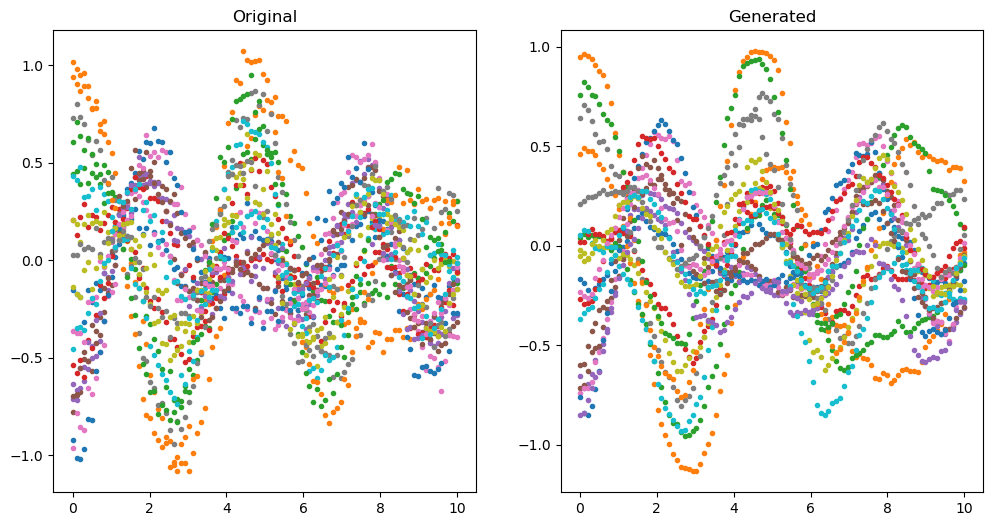

In [13]:
ns = 1
latent_dim=1
colors = plt.cm.jet(np.linspace(0, 10, ns))  # Using the 'jet' colormap; you can choose another
np.random.shuffle(colors)

# Create a figure and a set of subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns, optional figure size
#axs[0].set_ylim(10, 35)
#axs[1].set_ylim(10, 35)


for l in range(len(q_mu_l)):
    mu, var = [], []
    for i in range(latent_dim):
        with torch.no_grad():
            mu, var, _ = model.GP(X=t_uni, y=q_mu_l[l], q_var=q_var_l[l].squeeze())

    for i in range(ns):
        with torch.no_grad():
            z = model.reparameterization(mu, var.diag())
            dec = model.decode(z)
        axs[1].plot(t_uni, dec.numpy(), 'o', markersize=3)    

for i in df_damped['interval'].unique():
    id = df_damped['interval'] == i
    axs[0].plot(df_damped[id]['t'].to_numpy(), df_damped[id]['theta'].to_numpy(), 'o', markersize=3)

# Set titles for the subplots
axs[1].set_title('Generated')
axs[0].set_title('Original')

plt.show()  #

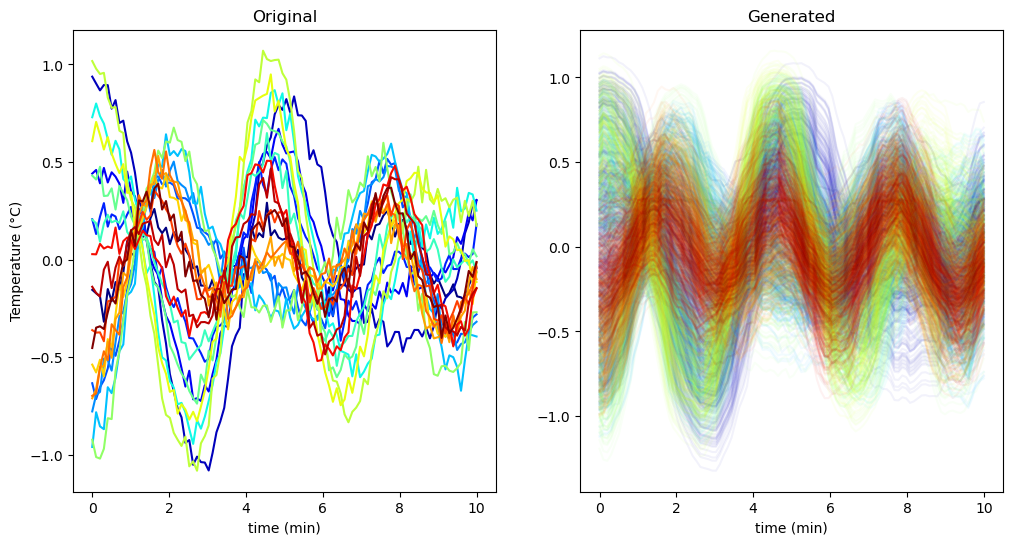

In [14]:
ns = 100
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
#axs[0].set_ylim(10, 35)
#axs[1].set_ylim(10, 35)

colors = plt.cm.jet(np.linspace(0, 1, len(q_mu_l)))

for l, color in zip(range(len(q_mu_l)), colors):
    mu_list, var_list = [], []
    for i in range(latent_dim):
        with torch.no_grad():
            mu, var, _ = model.GP(X=t_uni, y=q_mu_l[l], q_var=q_var_l[l].squeeze())
            mu_list.append(mu)
            var_list.append(var)

    for i in range(ns):
        with torch.no_grad():
            z = model.reparameterization(mu, var.diag())
            dec = model.decode(z)
        axs[1].plot(t_uni, dec.numpy(), color=color, alpha=0.05)

interval_indices = {interval: idx for idx, interval in enumerate(df_damped['interval'].unique())}

"""for i in df_damped['interval'].unique():
    id = df_damped['interval'] == i
    axs[0].plot(df_damped[id]['t'].to_numpy(), df_damped[id]['theta'].to_numpy(), 'o', markersize=3)"""
    
for i in df_damped['interval'].unique():
    id = df_damped['interval'] == i
    axs[0].plot(df_damped[id]['t'].to_numpy(), df_damped[id]['theta'].to_numpy(), color=colors[interval_indices[i]])

axs[1].set_title('Generated')
axs[1].set_xlabel('time (min)')
axs[0].set_ylabel('Temperature (°C)')
axs[0].set_title('Original')
axs[0].set_xlabel('time (min)')
# plt.savefig("../figs/GP_cool_cond.pdf", format='pdf')
plt.show()


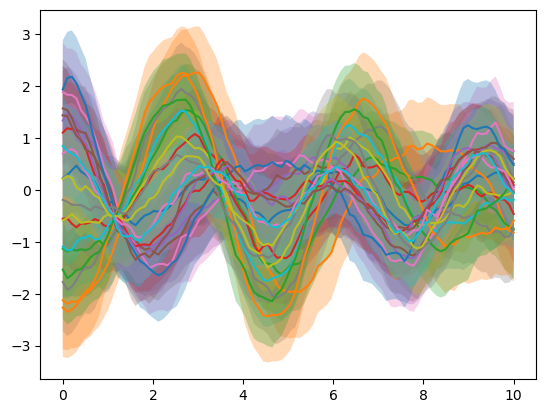

In [15]:
for l in range(len(q_mu_l)):
    with torch.no_grad():
        z_mu, z_var = model.GP.cond_mu_cov(t_uni, t_uni, q_mu_l[l], q_var_l[l].squeeze())
        plt.plot(t_uni,z_mu)
        plt.fill_between(t_uni, y1=z_mu.squeeze()+1.96*z_var.diag().sqrt(), y2=z_mu.squeeze()-1.96*z_var.diag().sqrt(),alpha=0.3, label='1.96*std')

plt.show()  #

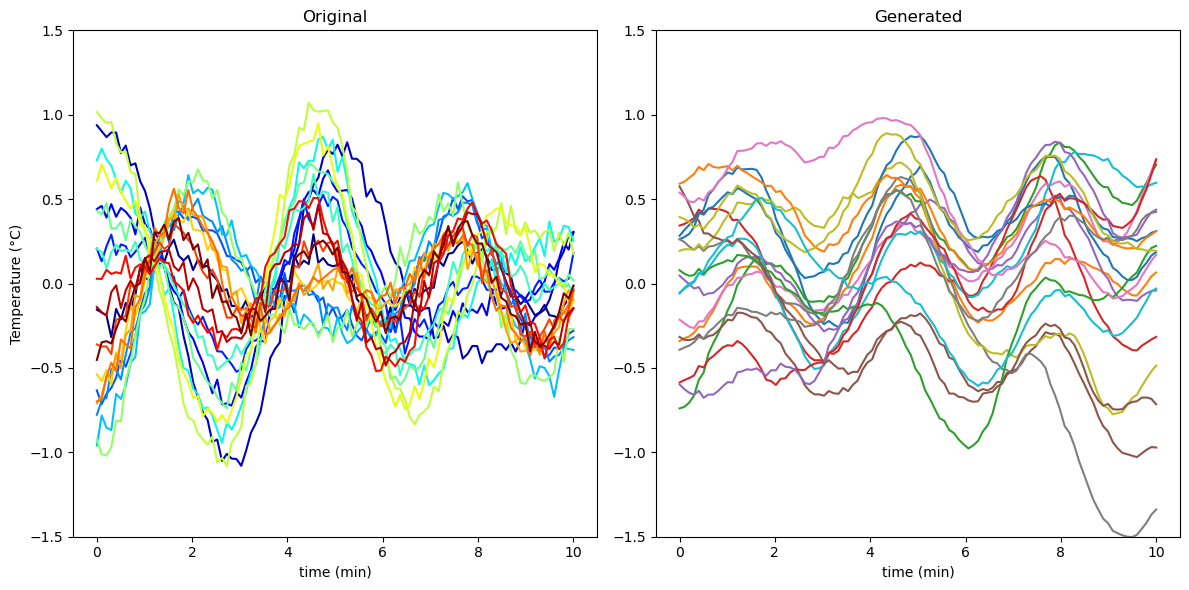

In [16]:
ns=total_size
mu_s = torch.cat(q_mu_l, dim=1).mean(dim=1).unsqueeze(1)
generated_data, fig = model.generate_and_plot(mu_s, t_uni/10, ns, (-1.5, 1.5), df_damped, plot=True, seed=10)


In [17]:
import tsgm
mmd_metric = tsgm.metrics.MMDMetric()
generated_data, fig = model.generate_and_plot(mu_s, t_uni, ns, (-1.5, 1.5), df_damped, plot=False, seed=2)
Gd = torch.stack(generated_data)
full_data = DataLoader(dataset)
original_data_list = []

# Iterate through the DataLoader
for batch in full_data:
    original_data_list.append(batch[0][:,0])

# Stack to create a tensor of shape [total_samples, 24, 1]
original_data = torch.stack(original_data_list)
original_data = original_data.unsqueeze(-1)
# Check the shape
# print(original_data.shape)
mmd_metric(original_data, Gd)

0.1835523749468848